In [1]:
import numpy as np
import matplotlib.pyplot as plt

分割超平面：
$\mathbf{w}^T\mathbf{x}+b$

数据点到平面的距离：
$\frac{|\mathbf{w}^T\mathbf{x}+b|}{||\mathbf{w}||}$

支持向量：距离分割超平面最近的**那些**点

SVM就是最大化支持向量到分割超平面的距离：
$\mathop{\arg\max\{\min{(label·(\mathbf{w}^T\mathbf{x}+b))·\frac{1}{||w||}}}\}$

通过拉格朗日乘子法优化目标函数：
$\max\{\sum_{i=1}^{m}{\alpha}-\frac{1}{2}\sum_{i,j=1}^m{label^{(j)}·\alpha_i·\alpha_j<x^{(i)}, x^{(j)}>}\}$<br> 
其中，约束条件为：$C\geq\alpha\geq0,\sum^m_{i-1}{\alpha_i·label^{(i)}=0}$<br>
这里的常数C用于控制“最大化间隔”和“保证大部分点的函数间隔小于1.0”

In [2]:
# SMO(Sequential Minimal Opimization)
# Find α and b to build hyperplane
# 每次循环种选择两个α进行优化处理。一旦找到一对合适的α，就增大其中一个同时减小另一个。
data_file = "./testSet.txt"
data = np.loadtxt(data_file, dtype=np.float, delimiter='\t')
# print(data)
data_mat = data[:,:2]
label_mat = data[:,-1]

In [3]:
print(data_mat.shape) #(100, 2)
print(label_mat.shape) # (100,)

(100, 2)
(100,)


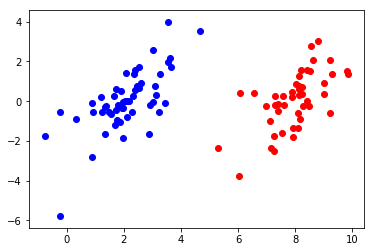

In [4]:
class_1 = np.array([])
class_0 = np.array([])
for i in range(100):
    if label_mat[i] == 1:
        class_1 = np.append(class_1, data_mat[i])
    else:
        class_0 = np.append(class_0, data_mat[i])

plt.scatter(class_1[0::2], class_1[1::2], color = 'red')
plt.scatter(class_0[0::2], class_0[1::2], color = 'blue')
plt.show()

In [5]:
# 随机选择一个m范围内不等于i的下标
def randAlpha(i, m):
    j = i
    while j==i:
        j = np.random.uniform(0,m)
    return int(j)

print(randAlpha(10,20))

17


In [6]:
def tuneAlpha(alpha, high, low):
    if alpha > high:
        alpha = high
    elif low > alpha:
        alpha = low
    return alpha

print(tuneAlpha(10, 3, 1))

3


In [14]:
'''
创建一个alpha向量，初始化为0向量
当迭代次数小于最大迭代次数时：
    对数据集中的每个数据向量：
        如果该数据向量可以被优化：
            随机选择另外一个数据向量
            同时优化这两个向量
            如果两个都不能被优化，退出
    如果所有向量都没被优化，增加迭代数目，继续下一次循环
'''

def SMO0(data, label, C, toler, iters):
    data_mat = np.mat(data)
    lable_mat = np.mat(label).transpose() # shape = (1, 100)
    b = 0
    m, n = data_mat.shape
    alphas = np.mat(np.zeros((m, 1)))
    cur_iter = 0  
    while cur_iter < iters:
        alpha_changed = 0
        for i in range(m):
            #             shape: (m,)                      (m,n)     (n,1)
            fXi = float(np.multiply(alphas, label_mat).T*(data_mat*data_mat[i,:].T)) + b
            # fXi = float(np.multiply(alphas, label_mat).T*(data_mat*data_mat[i,:].T)) + b
            Ei = fXi - float(label_mat[i])
            if ((label_mat[i]*Ei < -toler) and (alphas[i] < C)) or ((label_mat[i]*Ei > toler) and alphas[i] > 0):
                j = randAlpha(i, m)
                fXj = float(np.multiply(alphas, label_mat).T*(data_mat*data_mat[j,:].T)) + b
                Ej = fXj - float(label_mat[j])
                alpha_i = alphas[i].copy()
                alpha_j = alphas[j].copy()
                if(label_mat[i] != label_mat[j]):
                    low = max(0, alphas[j] - alphas[i])
                    high = min(C, C+alphas[j] - alphas[i])
                else:
                    low = max(0, alphas[j] + alphas[i] - C)
                    high = min(C, alphas[j] + alphas[i])
                if low == high:
                    print("low==high")
                    continue
                eta = 2.0*data_mat[i,:]*data_mat[j,:].T - \
                      data_mat[i,:]*data_mat[i,:].T - \
                      data_mat[j,:]*data_mat[j,:].T
                if eta >= 0:
                    print("eta>=0")
                    continue
                alphas[j] -= label_mat[j]*(Ei-Ej)/eta
                alphas[j] = tuneAlpha(alphas[j], high, low)
                if abs(alphas[j] - alpha_j) < 0.00001:
                    print("j is not moving enough")
                    continue
                alphas[i] += label_mat[j] * label_mat[i] * (alpha_j - alphas[j])
                b1 = b - Ei - label_mat[i] * (alphas[i] - alpha_i) * \
                     data_mat[i,:] * data_mat[i,:].T - \
                     label_mat[j] * (alphas[j]-alpha_j)*\
                     data_mat[i,:]*data_mat[j,:].T
                b2 = b - Ej - label_mat[i] * (alphas[i] - alpha_i) * \
                     data_mat[i,:] * data_mat[j,:].T - \
                     label_mat[j] * (alphas[j]-alpha_j)*\
                     data_mat[j,:]*data_mat[j,:].T
                if (0 < alphas[i]) and (C > alphas[i]):
                    b = b1
                elif (0 < alphas[j]) and (C > alphas[j]):
                    b = b2
                else: 
                    b = (b1+b2)/2.0
                alpha_changed += 1
                print("iter: %d, i: %d, alpha pairs changed times: %d"%(cur_iter, i, alpha_changed))
        if alpha_changed == 0:
            cur_iter+=1
        else:
            cur_iter = 0
        print("iter: %d"%cur_iter)
    return b, alphas

In [15]:
print(label_mat.transpose())
print(label_mat.transpose().shape)

[[-1. -1.  1. -1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1. -1.
   1. -1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1. -1.  1.  1.  1.  1. -1.
   1. -1. -1.  1. -1. -1. -1. -1.  1.  1.  1.  1.  1. -1.  1.  1. -1. -1.
   1.  1. -1.  1. -1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1. -1.  1.
   1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1.  1. -1.
   1.  1.  1. -1. -1. -1. -1. -1. -1. -1.]]
(1, 100)


In [17]:
data_mat = np.mat(data_mat)
label_mat = np.mat(label_mat).transpose()
b, alphas = SMO0(data_mat, label_mat, 0.6, 0.001, 40)

low==high
low==high
iter: 0, i: 2, alpha pairs changed times: 1
iter: 0, i: 3, alpha pairs changed times: 2
iter: 0, i: 4, alpha pairs changed times: 3
iter: 0, i: 5, alpha pairs changed times: 4
iter: 0, i: 8, alpha pairs changed times: 5
low==high
low==high
j is not moving enough
j is not moving enough
low==high
iter: 0, i: 32, alpha pairs changed times: 6
low==high
j is not moving enough
j is not moving enough
j is not moving enough
low==high
j is not moving enough
j is not moving enough
j is not moving enough
iter: 0, i: 54, alpha pairs changed times: 7
iter: 0, i: 55, alpha pairs changed times: 8
iter: 0, i: 59, alpha pairs changed times: 9
j is not moving enough
j is not moving enough
j is not moving enough
low==high
j is not moving enough
low==high
j is not moving enough
j is not moving enough
j is not moving enough
iter: 0, i: 81, alpha pairs changed times: 10
low==high
j is not moving enough
j is not moving enough
j is not moving enough
iter: 0
iter: 0, i: 1, alpha pairs chang

j is not moving enough
iter: 1
j is not moving enough
iter: 1, i: 23, alpha pairs changed times: 1
iter: 1, i: 26, alpha pairs changed times: 2
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 0
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 1
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 1, i: 54, alpha pairs changed times: 1
j is not moving enough
j is not moving enough
j is not moving enough
iter: 0
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 1
j is not moving enough
j is not moving enou

j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 5
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 6
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 7
j is not moving enough
j is not moving enough
j is not moving enough
j is not m

j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 3
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 4
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 5
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not m

j is not moving enough
j is not moving enough
iter: 1
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 2
j is not moving enough
iter: 2, i: 23, alpha pairs changed times: 1
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 0
j is not moving enough
j is not moving enough
j is not moving enough
eta>=0
iter: 0, i: 55, alpha pairs changed times: 1
j is not moving enough
iter: 0
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 1
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 2
j is not moving enough
j is not moving enough
iter: 2, i: 29, alpha pairs changed times: 1
j is not moving enough
j is not moving enough
j is not moving enough
iter:

iter: 1
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 2
j is not moving enough
j is not moving enough
j is not moving enough
iter: 2, i: 55, alpha pairs changed times: 1
iter: 0
j is not moving enough
j is not moving enough
j is not moving enough
iter: 0, i: 54, alpha pairs changed times: 1
j is not moving enough
iter: 0
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 1
eta>=0
j is not moving enough
j is not moving enough
j is not moving enough
iter: 2
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 3
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 4
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 5
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 6
j is not moving enough
j is not moving en

j is not moving enough
iter: 1
j is not moving enough
j is not moving enough
j is not moving enough
eta>=0
iter: 2
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 3
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 4
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 5
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 6
j is not moving enough
iter: 6, i: 23, alpha pairs changed times: 1
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 0
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
iter: 1
iter: 1, i: 29, alpha pairs changed times: 1
j is not moving enough
j is not moving enough
j is not moving enough
iter: 0
j is not moving enough
j is not moving enough
j is not moving enough
j is not moving enough
ite

iter: 1
j is not moving enough
j is not moving enough
j is not moving enough
iter: 2
j is not moving enough
j is not moving enough
j is not moving enough
iter: 3
j is not moving enough
j is not moving enough
j is not moving enough
iter: 4
j is not moving enough
j is not moving enough
j is not moving enough
iter: 5
j is not moving enough
j is not moving enough
j is not moving enough
iter: 6
j is not moving enough
j is not moving enough
j is not moving enough
iter: 7
j is not moving enough
j is not moving enough
j is not moving enough
iter: 8
j is not moving enough
j is not moving enough
j is not moving enough
iter: 9
j is not moving enough
j is not moving enough
j is not moving enough
iter: 10
j is not moving enough
j is not moving enough
j is not moving enough
iter: 11
j is not moving enough
j is not moving enough
j is not moving enough
iter: 12
j is not moving enough
j is not moving enough
j is not moving enough
iter: 13
j is not moving enough
j is not moving enough
j is not moving en

In [29]:
print(b)
print(alphas)

[[-3.83660331]]
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.11093914]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.24925802]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.0134597 ]
 [0.34673745]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.

In [18]:
support_vecs = np.array([])
for i in range(100):
    if alphas[i] > 0:
        print(data_mat[i], label_mat[i])y
        support_vecs = np.append(support_vecs, data_mat[i])

print(support_vecs)

[[4.658191 3.507396]] [[-1.]]
[[ 3.457096 -0.082216]] [[-1.]]
[[ 5.286862 -2.358286]] [[1.]]
[[6.080573 0.418886]] [[1.]]
[ 4.658191  3.507396  3.457096 -0.082216  5.286862 -2.358286  6.080573
  0.418886]


In [21]:
def calW(alphas, data, label):
    m,n = data_mat.shape
    w = np.zeros((n,1))
    for i in range(m):
        w += np.multiply(alphas[i]*label_mat[i], data_mat[i,:].T)
    return w

In [23]:
w = calW(alphas, data_mat, label_mat)

In [24]:
print(w)

[[ 0.8010374 ]
 [-0.25511288]]


In [27]:
x = np.arange(-2.0, 12, 0.1)
y = (-b-w[0]*x)/w[1]
y = y.T
print(x)
print(y)

[-2.00000000e+00 -1.90000000e+00 -1.80000000e+00 -1.70000000e+00
 -1.60000000e+00 -1.50000000e+00 -1.40000000e+00 -1.30000000e+00
 -1.20000000e+00 -1.10000000e+00 -1.00000000e+00 -9.00000000e-01
 -8.00000000e-01 -7.00000000e-01 -6.00000000e-01 -5.00000000e-01
 -4.00000000e-01 -3.00000000e-01 -2.00000000e-01 -1.00000000e-01
  1.77635684e-15  1.00000000e-01  2.00000000e-01  3.00000000e-01
  4.00000000e-01  5.00000000e-01  6.00000000e-01  7.00000000e-01
  8.00000000e-01  9.00000000e-01  1.00000000e+00  1.10000000e+00
  1.20000000e+00  1.30000000e+00  1.40000000e+00  1.50000000e+00
  1.60000000e+00  1.70000000e+00  1.80000000e+00  1.90000000e+00
  2.00000000e+00  2.10000000e+00  2.20000000e+00  2.30000000e+00
  2.40000000e+00  2.50000000e+00  2.60000000e+00  2.70000000e+00
  2.80000000e+00  2.90000000e+00  3.00000000e+00  3.10000000e+00
  3.20000000e+00  3.30000000e+00  3.40000000e+00  3.50000000e+00
  3.60000000e+00  3.70000000e+00  3.80000000e+00  3.90000000e+00
  4.00000000e+00  4.10000

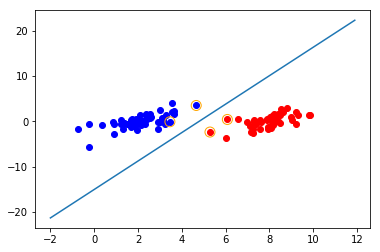

In [28]:
plt.scatter(class_1[0::2], class_1[1::2], color = 'red')
plt.scatter(class_0[0::2], class_0[1::2], color = 'blue')

plt.scatter(support_vecs[::2], support_vecs[1::2], marker='o', c='none', edgecolors='orange', s=100)
plt.plot(x, y)
plt.show()